# Содержание <a class="anchor" id="toc"></a>
- [Кластеризация методом `k-means`](#bullet-1)
  - [Постановка задачи](#bullet-1-2)
  - [В двух словах](#bullet-1-3)
  - [Инициализация центроидов](#bullet-1-4)
    - [Случайные точки области](#bullet-1-4-1)
    - [Случайная выборка](#bullet-1-4-2)
    - [Наиболее удалённые точки](#bullet-1-4-3)
    - [В одну функцию](#bullet-1-4-4)
  - [Установка тегов кластера](#bullet-1-5)
  - [Итеративный алгоритм](#bullet-1-6)
  - [Проверим результат](#bullet-1-7)
- [Выбор лучшего решения](#bullet-2)
  - [Самое частое решение](#bullet-2-1)
    - [Недостаток](#bullet-2-1-1)
  - [Sum of Squares Within](#bullet-2-2)
    - [Недостаток](#bullet-2-2-1)
- [Выбор числа кластеров](#bullet-3)
  - [Проверим на тестовых данных](#bullet-3-1)
  - [Недостаток](#bullet-3-2)
- [Зависимость времени выполнения от объёма данных](#bullet-4)
- [Исследование эвристик инициализации на точность](#bullet-5)
  - [Стратегия `sample`](#bullet-5-1)
  - [Стратегия `random`](#bullet-5-2)
  - [Стратегия `distant`](#bullet-5-3)
- [Матрица попарных расстояний](#bullet-6)
- [Многомерные точки](#bullet-7)
- [Описание библиотеки `clust`](#bullet-8)
  - [Класс `KMeans`](#bullet-8-1)
  - [Класс `elbow`](#bullet-8-2)
  - [Класс `pair_matrix`](#bullet-8-3)
  - [Класс `Test_time`](#bullet-8-4)
  - [Класс `Test_heur`](#bullet-8-5)
  - [Класс `Test_dim`](#bullet-8-6)

# Кластеризация методом k-means <a class="anchor" id="bullet-1"></a>

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from clust import KMeans
from clust import pair_matrix
from clust import Test_time

## Постановка задачи <a class="anchor" id="bullet-1-2"></a>
Даны точки: $X=\{x_1, \ x_2, \ \ldots, \ x_m\}\subset\mathbb{R}^n$. Распределить их по группам (**кластерам**) с помощью алгоритма **k-means**.

In [2]:
n_clusters = 3
n_points = 2000
n_features = 2
X, tags = make_blobs(n_samples=n_points, n_features=n_features, centers=n_clusters, random_state=0)

## В двух словах <a class="anchor" id="bullet-1-3"></a>
1. Определить число $k$ – оптимальное число кластеров;
2. Инициализировать точки $M=\{\mu_1, \ \mu_2, \ \ldots, \ \mu_k\}$ – центры кластеров (**центроиды**);
3. Решить итеративным алгоритмом

## Инициализация центроидов <a class="anchor" id="bullet-1-4"></a>
### Случайные точки области <a class="anchor" id="bullet-1-4-1"></a>
**Идея**: выберем случайные точки из области $G\subset\mathbb{R}^n$, которая содержит все точки из $X$

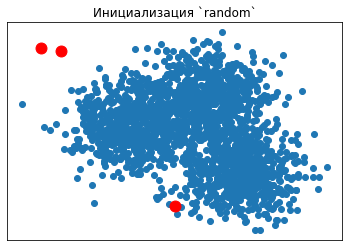

In [3]:
def init_random():
    global centroids
    min_coords = np.min(X, axis=0)
    max_coords = np.max(X, axis=0)

    coords = np.zeros((n_features, n_clusters))
    for i in range(n_features):
        coords[i] = np.random.rand(n_clusters) * (max_coords[i] - min_coords[i]) + min_coords[i]

    centroids = coords.T

init_random()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

plt.tick_params(axis="y", which="both", left=False, labelleft=False)
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
plt.title("Инициализация `random`")
plt.show()

### Случайная выборка <a class="anchor" id="bullet-1-4-2"></a>
**Идея**: создадим случайную выборку длины $k$ из точек массива $X$

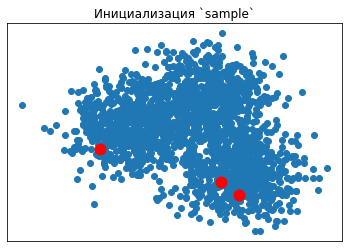

In [4]:
def init_sample():
    global centroids, indeces
    indeces = np.random.choice(np.arange(X.shape[0]), n_clusters, replace=False)
    centroids = np.copy(X[indeces])

init_sample()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

plt.tick_params(axis="y", which="both", left=False, labelleft=False)
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
plt.title("Инициализация `sample`")
plt.show()

### Наиболее удалённые точки <a class="anchor" id="bullet-1-4-3"></a>
**Идея**:
- первую точку выберем среди точек $X$
- вторую точку найдём как наиболее удалённую от первой
- третью точку найдём как наиболее удалённую от первой и второй точек
- и так далее

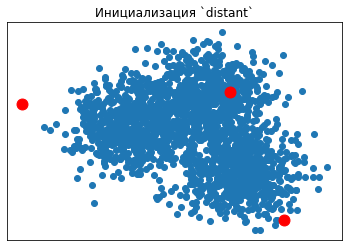

In [5]:
def compute_distance_matrix(centr_ind):   
    res = np.zeros((centr_ind, n_points))
        
    for i in range(centr_ind):
        res[i] = np.linalg.norm(X - centroids[i], axis=1)

    res = res.T

    return res

def init_distant():
    global indeces, centroids
    indeces = np.zeros(n_clusters, dtype=int)
    centroids = np.zeros((n_clusters, n_features))

    t = np.random.randint(0, n_points, size=1)
    indeces[0] = t
    centroids[0] = X[t]

    for i in range(1, n_clusters):
        t = np.nanargmax(np.nanmean(compute_distance_matrix(i), axis=1))
        indeces[i] = t
        centroids[i] = X[t]

init_distant()
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

plt.tick_params(axis="y", which="both", left=False, labelleft=False)
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
plt.title("Инициализация `distant`")
plt.show()

### В одну функцию <a class="anchor" id="bullet-1-4-4"></a>

In [6]:
def init_centr(heur):
        dct = {
            "sample": init_sample,
            "random": init_random,
            "distant": init_distant,
        }
        dct[heur]()

## Установка тегов кластера <a class="anchor" id="bullet-1-5"></a>
Дальше нужно распределить точки массива $X$ по кластерам $C_1, \ C_2, \ \ldots, C_k$. Точка относится к тому кластеру, чей центр ей ближе:
$$C_i=\{x\in X: \|x-\mu_i\|=\min\limits_{\mu} \|x-\mu\|\}$$
Значит, нужно определить для каждого $x\in X$, какой центр ближе

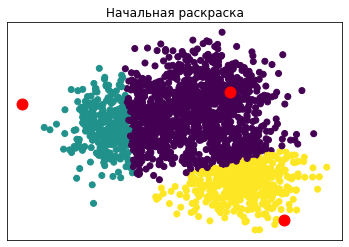

In [7]:
def near_center(point):
    return np.argmin(np.linalg.norm(centroids - point, axis=1))

labels = np.zeros(n_points)
def set_labels():
    global labels
    for i in range(n_points):
        labels[i] = near_center(X[i])

set_labels()

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

plt.tick_params(axis="y", which="both", left=False, labelleft=False)
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
plt.title("Начальная раскраска")
plt.show()

## Итеративный алгоритм <a class="anchor" id="bullet-1-6"></a>
Алгоритм называется итеративным, если он находит решение задачи как предел некоторой последовательности. 
Каждая итерация k-means состоит из двух шагов:

1. **Assignment**. Приписать каждый объект к ближайшему центру;
2. **Update**. Пересчитать центроиды как центры масс кластеров, полученых на шаге assignment.
Алгоритм прерывают тогда, когда достигнута заранее установленная точность.

Поскольку массив центроидов – это матрица $k\times n$, то мы прервём алгоритм когда выполнится условие:
$$\|M_n-M_{n+1}\|_F\leqslant\varepsilon,$$
где $\|\cdot\|_F$ – норма Фробениуса

In [8]:
def update_centers():
    global centroids
    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        centroids[i] = X[labels == i].mean(axis=0)
    return centroids

def perform(heur='sample', prec=0.001):
    init_centr(heur)
    set_labels()

    while (np.linalg.norm(centroids - update_centers()) > prec):
        set_labels()
        
    set_labels()

perform()

## Проверим результат <a class="anchor" id="bullet-1-7"></a>

Text(0.5, 1.0, 'Исходные кластеры')

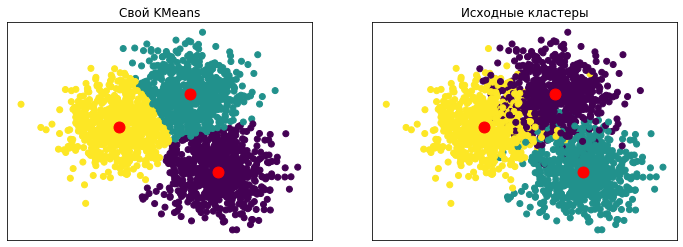

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(X[:, 0], X[:, 1], c=labels)
ax[0].scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

ax[1].scatter(X[:, 0], X[:, 1], c=tags)
ax[1].scatter(centroids[:, 0], centroids[:, 1], s=120, c='red')

ax[0].tick_params(axis="y", which="both", left=False, labelleft=False)
ax[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax[1].tick_params(axis="y", which="both", left=False, labelleft=False)
ax[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

ax[0].set_title("Свой KMeans")
ax[1].set_title("Исходные кластеры")

# Выбор лучшего решения <a class="anchor" id="bullet-2"></a>
k-means чувствителен к начальной инициализации: если два начальных центроида окажутся в области точек, изолированных от других, то решение почти гарантированно будет неверным.
Поэтому будем прогонять алгоритм `n_start` раз и затем выбирать лучший ответ.
Заодно добавим "апгрейд": сортировку точек массива $X$ по кластерам
## Самое частое решение <a class="anchor" id="bullet-2-1"></a>
Среди всех вычисленных конфигураций найдём ту, которая отлична от других меньше всего.
### Недостаток <a class="anchor" id="bullet-2-1-1"></a>
При увеличении числа кластеров или при использовании эвристики `random` (об этом позже) это улучшение слабо помогает. Лучше всего его использовать при малом числе кластеров и с эффективной эвристикой `sample` (об этом позже).
## Sum of Squares Within <a class="anchor" id="bullet-2-2"></a>
Для каждого кластера посчитаем сумму квадратов отклонений каждой точки от своего центра, т.е.
$$SSW_{i}= \sum_{j=1}^{|C_i|} \|x_j-\mu_i\|^2$$
Затем сложим все суммы. Полученное число будет мерой совокупной однородности кластеров: чем оно меньше, тем однороднее кластеры.

### Недостаток <a class="anchor" id="bullet-2-2-1"></a>
Не самый точный метод. Высокая эффективность достигается только на гауссовых каплях

# Выбор числа кластеров <a class="anchor" id="bullet-3"></a>
Будем находить оптимальное число кластеров **методом локтя** (*elbow method*): прогоним алгоритм на одних и тех же данных, указывая разные количества кластеров, и построим график $SSW$. Число кластеров, при котором график превращается в почти горизонтальный будет оптимальным

In [10]:
class elbow:
    """
    the way to find optimal clusters count
    """
    def __init__(self, X, n_features, heur='sample', kmax=10, n_start=3):
        self.kmax = kmax
        self.variances_for_k = np.zeros(kmax)
        self.models = []
        for k in range(kmax):
            m = KMeans(X, n_clusters=k+1, n_features=n_features).fit(heur=heur, n_start=n_start)
            self.variances_for_k[k] = m.SSW
            self.models.append(m)
        
    def choose_k(self):
        """
        looks through the values of SSW to find optimal count.
        perfectly works with gaussian blobs
        """
        diffrences = np.zeros(self.kmax)
        for k in range(1, self.kmax):
            diffrences[k] = self.variances_for_k[k - 1] - self.variances_for_k[k]
        
        proportions = np.zeros(self.kmax)
        for k in range(1, self.kmax):
            proportions[k] = diffrences[k] / self.variances_for_k[k]
        
        
        return np.argmin(proportions[1:]) + 1

## Проверим на тестовых данных <a class="anchor" id="bullet-3-1"></a>

In [11]:
X, tags = make_blobs(n_samples=500, n_features=2, centers=4, random_state=0)
solve = elbow(X, n_features=2, kmax=7)

Text(4, 780.9895856451146, 'real')

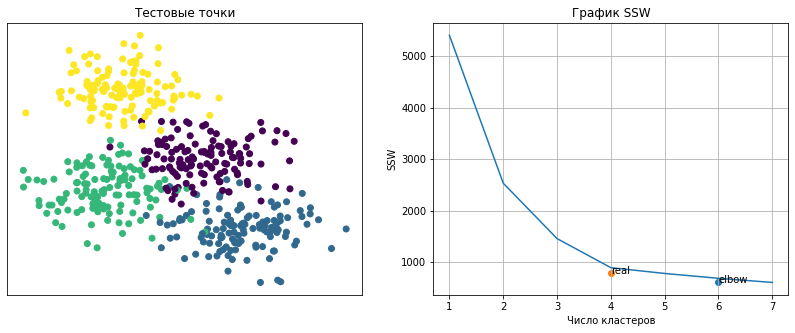

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(X[:, 0], X[:, 1], c=tags)
ax[0].tick_params(axis="y", which="both", left=False, labelleft=False)
ax[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax[0].set_title("Тестовые точки")

ax[1].plot(np.arange(1, solve.kmax + 1), solve.variances_for_k)
ax[1].set_title("График SSW")
ax[1].grid()
ax[1].set_xlabel("Число кластеров")
ax[1].set_ylabel("SSW")
k = solve.choose_k()
ax[1].scatter(k, solve.variances_for_k[k])
ax[1].annotate("elbow", [k, solve.variances_for_k[k]])
ax[1].scatter(4, solve.variances_for_k[4])
ax[1].annotate("real", [4, solve.variances_for_k[4]])

In [13]:
print(f"optimal cluster count is {solve.choose_k()}")

optimal cluster count is 6


## Недостаток <a class="anchor" id="bullet-3-2"></a>
Метод не точен. Но даже если принять, что точен, то сложность в том, чтобы автоматизировать анализ графика SSW. Человек, просто взглянув на график SSW, всегда сделает это точнее.

# Зависимость времени выполнения от объёма данных <a class="anchor" id="bullet-4"></a>
Написан класс `Time_test()`

![](https://i.postimg.cc/YSjzXCwq/plot.png)

# Исследование эвристик на точность <a class="anchor" id="bullet-5"></a>
Для этого я написал класс `Test_heur`, который строит таблицу графиков: вдоль горизонтали увеличивается количество точек (от 100 до 1000), а вдоль вертикали увеличивается число кластеров (от 1 до 10). В каждой ячейке таблицы результат применения `Kmeans`. Проверял на гауссовских каплях из `sklearn.datasets.make_blobs`.

## Стратегия sample <a class="anchor" id="bullet-5-1"></a>
Работает лучше остальных. <span style="color:green">**Явных ошибок: 16/90**</span>.

![](https://i.postimg.cc/25J0KvK1/sample.png)

## Стратегия random <a class="anchor" id="bullet-5-2"></a>
Работает отвратительно. <span style="color:red">**Всего верно: 27/90**</span>. Замечено, что если запускать `random` по разу, а не пачкой, как тут, то такие "ломания" алгоритма практически не случаются. Не смог выяснить, с чем это связано; скорее всего, это связано с библиотекой `numpy.random`

![](https://i.postimg.cc/j2YZsTKK/random.png)

## Стратегия distant <a class="anchor" id="bullet-5-3"></a>
Работает лучше, чем `random`, но хуже, чем `sample`. <span style="color:orange">**Явных ошибок: 32/90**</span>.

![](https://i.postimg.cc/vT7XTKHn/distant.png)

# Матрица попарных расстояний <a class="anchor" id="bullet-6"></a>
Это графический способ понять:
- насколько кластеры однородны
- насколько кластеры отделены друг от друга

Поскольку формальным результатом кластеризации является массив точек `X` и вектор тэгов `label`, то для составления матрицы попарных расстояний достаточно отсортировать `X` одновременно с `label`. Реализовано в виде функции `compute_pair_distances()`. Чтобы смотреть структуру отдельных кластеров, написана функция `get_pair_submatrix()`
![](https://i.postimg.cc/Xvm0krK8/pair-matrix.png)

# Многомерные точки <a class="anchor" id="bullet-7"></a>

`KMeans` работает и в случае $\mathbb{R}^n, \ n\geqslant 3$. Чтобы проверить это, достаточно построить матрицу попарных расстояний.

![](https://i.postimg.cc/qq93rnFg/dim-sample.png)

# Описание библиотеки `clust` <a class="anchor" id="bullet-8"></a>
Весь код оформлен в библиотеку `clust`. Здесь не все методы и атрибуты, а только те, которые имеет смысл использовать после отработки алгоритма

## Класс `KMeans` <a class="anchor" id="bullet-8-1"></a>
Это класс, который содержит все функции, необходимые для полного "цикла жизни" алгоритма кластеризации:
- инициализация
- установка тегов
- `update` центроидов
- запуск нескольких конфигураций и выбор лучшего результата
- сортировка точек

### `__init__(self, X, n_clusters, n_features=2)`
X is array of points with dimension `n_features`

### `near_center(self, point)`
Для точки `point` возвращает индекс ближайшего центроида в массиве `self.centroids`

### `what_cluster(self,point)`
Для точки `point` возвращает координаты ближайшего центроида

### `fit(self, heur="sample", n_start=3, prec=0.001)`
запускает `n_start` конфигураций алгоритма и выбирает наилучший результат, основываясь на total SSW; перед завершением запускает сортировку точек

### `self.n_clusters`
Число кластеров, переданное при инициализации

### `self.n_features`
Размерность точек во входном массиве

### `self.X`
Массив входных данных. Отличается от переданного при инициализации тем, что отсортирован по кластерам.

### `self.n_points`
Число точек в массиве `self.X`

### `self.centroids`
Массив координат центроидов

### `self.labels`
Вектор такой же длины, что и массив `self.X`

### `within_cluster_squares`
Вектор внутрикластерных вариаций

## Класс `elbow` <a class="anchor" id="bullet-8-2"></a>
Это класс, в котором реализован выбор оптимального числа кластеров

### `__init__(self, X, n_features=2, heur="sample", kmax=10, n_start=3)`
При создании объекта класса `elbow`, происходит прогонка  алгоритма `k-means` при разных `k` (от 1 до `kmax`) по переданным тестовым данным `X`. В качестве параметром инициализации передаются параметры настройки `k-means`.

### `choose_k(self)`
возвращает оптимальное число кластеров

## Класс `pair_matrix` <a class="anchor" id="bullet-8-3"></a>
Это класс, который реализует построение и отрисовку матриц попарных расстояний

### `compute_pair_distances(model)`
Для переданного объекта `model` класса `KMeans` строится матрица попарных расстояний. Она присваивается объекту класса `pair_matrix` в качестве атрибута

### `get_pair_submatrix(model, *clust_nums)`
для матрицы попарных расстояний возвращает её главную подматрицу с кластерами, обозначенными переданными индексами `*clust_nums`

### `plot(n_points=2000, n_clusters=5)`
рисует таблицу графиков, состоящую из трёх столбцов: кластеры на плоскости, матрица попарных расстояний текущего кластера, гистограмма распределения расстояний от точек кластера до центра. сохраняет рисунок в текущую директорию

## Класс `Test_time` <a class="anchor" id="bullet-8-4"></a>
Это класс, нужный для исследования зависимости времени выполнения от объёма данных и отрисовки соответствующего графика

### `__init__(self, points_range=[10, 101], points_step=10, n_clusters=7)`
прогоняет `kmeans` по разным входным данным, у которых количество точек меняется в пределах `points_range` с шагом `points_step`; число кластеров изменяется от 1 до `n_clusters`. во время работы сохраняет результат в файл `data.npy` в директории `f"time_{date.tm_year}_{date.tm_mon}_{date.tm_mday}_{date.tm_hour}_{date.tm_min}_{date.tm_sec}"`

### `plot(self, heur)`
строит `plt.stackplot` с заголовком `f"Время работы `kmeans` ({heur})"` и сохраняет его в директории теста, где сохранялся файл `data.npy`

## Класс `Test_heur` <a class="anchor" id="bullet-8-5"></a>
Это класс, нужный для исследования разных стратегий инициализации на точность. Строит соответствующую таблицу и сохраняет рисунок в текущую директорию

### `__init__(self, points_range=[100, 1000], points_step = 100, n_clusters=10)`
прогоняет `kmeans` по разным входным данным, у которых количество точек меняется в пределах `points_range`с шагом `points_step`; число кластеров изменяется от 1 до `n_clusters`.

### `plot(self,heur)`
вдоль горизонтали увеличивается количество точек (от 100 до 1000), а вдоль вертикали увеличиваетсячисло кластеров (от 1 до 10). В каждой ячейке таблицы результат применения `Kmeans`. В качестве тестовых данных `sklearn.datasets.make_blobs`.

## Класс `Test_dim` <a class="anchor" id="bullet-8-6"></a>
нужен для проверки работы `kmeans` на многомерних точках, строит соответствующую табллицу

### `__init__(self, heur, n_features=4, points_range=[100, 1000], points_step=100, n_clusters=10)`
прогоняет `kmeans` по разным входным данным, у которых количество точек меняется в пределах `points_range`с шагом `points_step`; число кластеров изменяется от 1 до `n_clusters`.

### `plot(self)`
вдоль горизонтали увеличивается количество точек (от 100 до 1000), а вдоль вертикали увеличивается число кластеров (от 1 до 10). В каждой ячейке таблицы результат применения `Kmeans`. В качестве тестовых данных `sklearn.datasets.make_blobs`.
